In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform
%matplotlib inline
plt.style.use('ggplot')

In [84]:
data_mat = pd.read_csv("../data/student-mat.csv", sep=";")

In [85]:
data_mat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [86]:
data_por = pd.read_csv("../data/student-por.csv", sep=";")

In [87]:
data_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [88]:
stats.ks_2samp(data_mat['Walc'], data_por['Walc'])

Ks_2sampResult(statistic=0.014241969144350608, pvalue=0.99999999971045828)

Тест однородности Колмогорова-Смирнова, чтобы проверить гипотезу о том, что потребление алкоголя в выходные дни
студентами из двух выборок принадлежит одному закону распределения

In [89]:
stats.ks_2samp(data_mat['Dalc'], data_por['Dalc'])

Ks_2sampResult(statistic=0.0072516627333190087, pvalue=1.0000000000000002)

Такой же тест, только употребление в рабочие дни. Как можно увидеть K-S статистика очень мала, а p-value высоко, по этой причине можно сделать вывод, что выборки принадлежат одинаковому распределению и мы можем их сконкатенировать и не бояться, что точность предсказания упадет по сравнению с предсказанием употребления алкоголя по отдельности.

Будние дни и рабочие дни объединим в один столбец. Этот столбец будет метками.

In [90]:
def process_alc(data):
    result = data
    result['alc'] = data.apply(lambda row: ((row['Dalc'] * 5.0) + (row['Walc'] * 2.0)) / 7, axis = 1)
    result.drop(['Dalc', 'Walc'], inplace = True, axis = 1)
    return result


Так как в двух выборках есть одинковые студенты и в описании датасета сказано по каким аттрибутам их искать, то конкатенацию делаем по этим признакам

In [91]:
students = pd.concat([data_mat, data_por]).groupby(["school",
                                                          "sex",
                                                          "age",
                                                          "address",
                                                          "famsize",
                                                          "Pstatus",
                                                          "Medu",
                                                          "Fedu",
                                                          "Mjob",
                                                          "Fjob",
                                                          "reason",
                                                          "nursery",
                                                          "internet"]).mean().reset_index()

students.shape

(662, 26)

Объединяем столбцы

In [92]:
students = process_alc(students)

Делаем нелинейное преобразование признаков, так как вклад некоторых признаков достаточно нелинейен и для улучшения точности распознавания необходимо произвести преобразование

In [93]:
students_transformed = students
students_transformed['male'] = students['sex'] == "M"
students_transformed['rural'] = students['address'] == "R"
students_transformed['big_family'] = students['famsize'] == 'GT3'
students_transformed['parents_together'] = students['Pstatus'] == "T"
students_transformed['studies_less'] = students['studytime'] < 3
students_transformed['more_failures'] = students['failures'] >= 2
students_transformed['bad_relationships'] = students['famrel'] <= 2
students_transformed['more_free_time'] = students['freetime'] > 3
students_transformed['goes_out_more'] = students['goout'] > 4
students_transformed['bad_health'] = students['health'] <= 2
students_transformed['high_absences'] = students['absences'] > (students['absences'].std() * 2)
students_transformed['drinker'] = students['alc'] >= 3
students_transformed['mothers_low_edu'] = students['Medu'] <= 3
students_transformed['fathers_low_edu'] = students['Fedu'] <= 3
students_transformed['more_than_18'] = students['age'] > 18
students_transformed['long_road'] = students['traveltime'] >= 3

sum_grade = students['G1'] + students['G2'] + students['G3']
mean_grade = (sum_grade) / 3 
students_transformed['low_grade'] = mean_grade <= (mean_grade.mean() + mean_grade.std())

students_transformed.drop(['sex', 
                           'address', 
                           'famsize', 
                           'Pstatus', 
                           'studytime', 
                           'failures', 
                           'famrel', 
                           'freetime', 
                           'goout', 
                           'health',
                           'absences',
                           'alc',
                           'G1',
                            'G2',
                            'G3',
                           'Medu',
                           'Fedu',
                           'age',
                           'traveltime'], axis = 1, inplace = True)

In [94]:
data = students_transformed.drop('drinker', axis = 1)
data = pd.get_dummies(data)
target = students_transformed['drinker']
x_train, x_val, y_train, y_val = cross_validation.train_test_split(data, target, test_size=0.2, random_state=123, stratify = target)

RandomForset классификатор со случайным поиском параметров, используется 5-fold кросс-валидация.

In [95]:
rf_clf = RandomForestClassifier(class_weight = "balanced")
rf_param_dist ={"n_estimators" : np.arange(10, 100, 10),
                  "max_depth": sp_randint(1, 31),
                  "max_features": sp_randint(1, 10),
                  "min_samples_split": sp_randint(1, 11),
                  "min_samples_leaf": sp_randint(1, 11),
                  "max_features" : ["auto", "sqrt", "log2"],
                  "criterion": ["gini", "entropy"]}

n_iter_search = 250
rf_random_search = RandomizedSearchCV(rf_clf, param_distributions = rf_param_dist,
                                   n_iter = n_iter_search, random_state = 123, cv=5)
rf_random_search.fit(x_train, y_train)
rf_clf = rf_random_search.best_estimator_
rf_val_score = rf_clf.score(x_val, y_val)
print("Best randomized search score - %s" % rf_random_search.best_score_)
print("Validation score - %s" % rf_val_score)

Best randomized search score - 0.877126654064
Validation score - 0.87969924812


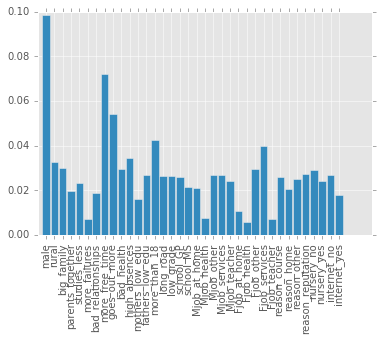

In [24]:
ax = plt.subplot(111)
width = 0.9
names = x_train.columns
bins = list(map(lambda x: x - width / 2, range(1, len(rf_clf.feature_importances_) + 1)))
ax.bar(bins, rf_clf.feature_importances_, width = width)
ax.set_xticks(list(map(lambda x: x, range(1, len(rf_clf.feature_importances_) + 1))))
ax.set_xticklabels(names,rotation = 90)

plt.show()

GradientBossting классификатор со случайным поиском параметров, используется 5-fold кросс-валидация.

In [25]:
gb_param_dist = {"n_estimators" :  np.arange(10, 200, 10),
                  "max_depth": sp_randint(2, 31),
                  "learning_rate" : uniform(loc = 0.01, scale=0.2),
                  }
gb_clf = GradientBoostingClassifier()

n_iter_search = 250
gb_random_search = RandomizedSearchCV(gb_clf, param_distributions = gb_param_dist,
                                   n_iter = n_iter_search, random_state = 123, cv=5)
gb_random_search.fit(x_train, y_train)
gb_clf = gb_random_search.best_estimator_
gb_val_score = gb_clf.score(x_val, y_val)
print("Best randomized search score - %s" % gb_random_search.best_score_)
print("Validation score - %s" % gb_val_score)

Best randomized search score - 0.882797731569
Validation score - 0.87969924812


Выберем 10 лучших признаков

In [29]:
t = []
for i in range(0, len(x_train.columns)):
    t.append((x_train.columns[i], gb_clf.feature_importances_[i]))
sorted_by_second = sorted(t, key=lambda tup: tup[1], reverse=True)
best_features = [x[0] for x in sorted_by_second][:10]

In [30]:
best_features

['rural',
 'Mjob_other',
 'high_absences',
 'goes_out_more',
 'Mjob_services',
 'long_road',
 'Fjob_services',
 'male',
 'school_MS',
 'school_GP']

In [31]:
data = data[best_features]
x_train, x_val, y_train, y_val = cross_validation.train_test_split(data, target, test_size=0.2, 
                                                                   random_state=123, stratify = target)

GradientBossting классификатор с отобранными признаками и со случайным поиском параметров, используется 5-fold кросс-валидация. Как можно заметить точность на лучшей модели улучшилась но на тестовой выборке ничего не изменилось.

In [32]:
gb_param_dist = {"n_estimators" :  np.arange(10, 200, 10),
                  "max_depth": sp_randint(2, 31),
                  "learning_rate" : uniform(loc = 0.01, scale=0.2),
                  }
gb_clf = GradientBoostingClassifier()

n_iter_search = 250
gb_random_search = RandomizedSearchCV(gb_clf, param_distributions = gb_param_dist,
                                   n_iter = n_iter_search, random_state = 123, cv=5)
gb_random_search.fit(x_train, y_train)
gb_clf = gb_random_search.best_estimator_
gb_val_score = gb_clf.score(x_val, y_val)
print("Best randomized search score - %s" % gb_random_search.best_score_)
print("Validation score - %s" % gb_val_score)

Best randomized search score - 0.888468809074
Validation score - 0.87969924812


Посмотрим гистрограммы по признаками и попробуем выявить типовые группы студентов, характеризующих наиболее различное поведение в потреблении алкоголя

Пьющих мальчиков около 50 из 200, то есть 25% можно считать пьющими. Девочки почти не пьют.

In [44]:
boys = students_transformed[students_transformed['male'] == True]
girls = students_transformed[students_transformed['male'] == False]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000015C36278>]], dtype=object)

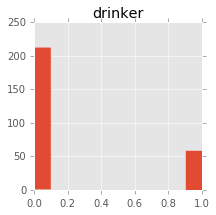

In [46]:
boys.hist(column='drinker', figsize=(3, 3))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000015912A20>]], dtype=object)

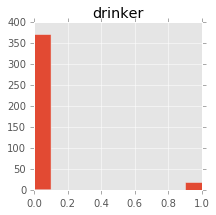

In [48]:
girls.hist(column='drinker', figsize=(3, 3))

Cреди мало пропускающих занятия 10% любят выпить. Среди много пропускающих 28%. 

In [79]:
data1 = students_transformed[(students_transformed['high_absences'] == False) & (students_transformed['drinker'] == True)]
data2 = students_transformed[(students_transformed['high_absences'] == False)]
print(1.0*len(data1)/len(data2))

0.103448275862


In [76]:
data1 = students_transformed[(students_transformed['high_absences'] == True) & (students_transformed['drinker'] == True)]
data2 = students_transformed[(students_transformed['high_absences'] == True)]
print(1.0*len(data1)/len(data2))

0.283018867925


Среди любящих погулять пьют 25%, а среди нелюбящих 9%.

In [80]:
data1 = students_transformed[(students_transformed['goes_out_more'] == False) & (students_transformed['drinker'] == True)]
data2 = students_transformed[(students_transformed['goes_out_more'] == False)]
print(1.0*len(data1)/len(data2))

0.0920577617329


In [81]:
data1 = students_transformed[(students_transformed['goes_out_more'] == True) & (students_transformed['drinker'] == True)]
data2 = students_transformed[(students_transformed['goes_out_more'] == True)]
print(1.0*len(data1)/len(data2))

0.25
